## Import, Clean, Select and/or Simulate Data

In [365]:
# Select Data
dataset_choice = 'custom' # options: telemetrum, telemega, custom

In [366]:
# Import libraries, define natural constants, helper functions
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

R_universal = 8.3144598 # J/(mol*K)
R_specific_air = 287.058 # J/(kg*K)
MM_air = 0.0289644 # kg/mol
F_gravity = 9.80665 # m/s^2
T_lapse_rate = 0.0065 # K/m

def temp_at_height(h, temp_at_launchpad):
    return temp_at_launchpad - (h*T_lapse_rate)

def pressure_at_height(h, temp_at_launchpad, pressure_at_launchpad):
    return pressure_at_launchpad*(pow((1-(h*T_lapse_rate/(temp_at_launchpad+273.15))),(F_gravity*MM_air/(R_universal*T_lapse_rate)))) 
    # Pressure at the launch site was around 87 kPa for Prometheus' launch

def air_density_fn(pressure, temp):
    return pressure/(R_specific_air*(temp+273.15))

one_atm_air_dynamic_viscosity_lookup = { # https://www.me.psu.edu/cimbala/me433/Links/Table_A_9_CC_Properties_of_Air.pdf
    -150:8.636*pow(10,-6),
    -100:1.189*pow(10,-6),
    -50:1.474*pow(10,-5),
    -40:1.527*pow(10,-5),
    -30:1.579*pow(10,-5),
    -20:1.630*pow(10,-5),
    -10:1.680*pow(10,-5),
    0:1.729*pow(10,-5),
    5:1.754*pow(10,-5),
    10:1.778*pow(10,-5),
    15:1.802*pow(10,-5),
    20:1.825*pow(10,-5),
    25:1.849*pow(10,-5),
    30:1.872*pow(10,-5),
    35:1.895*pow(10,-5),
    40:1.918*pow(10,-5),
    45:1.941*pow(10,-5),
    50:1.963*pow(10,-5),
    60:2.008*pow(10,-5),
    70:2.052*pow(10,-5),
}

def lookup_dynamic_viscosity(temp, one_atm_air_dynamic_viscosity_lookup):
    temp_list = list(one_atm_air_dynamic_viscosity_lookup.keys())
    if temp <= temp_list[0]:
        return one_atm_air_dynamic_viscosity_lookup[temp_list[0]]
    elif temp >= temp_list[-1]:
        return one_atm_air_dynamic_viscosity_lookup[temp_list[-1]]
    else:
        lower_temp = max([t for t in temp_list if t < temp])
        upper_temp = min([t for t in temp_list if t > temp])
        lower_viscosity = one_atm_air_dynamic_viscosity_lookup[lower_temp]
        upper_viscosity = one_atm_air_dynamic_viscosity_lookup[upper_temp]
        return lower_viscosity + (temp - lower_temp) * (upper_viscosity - lower_viscosity) / (upper_temp - lower_temp)

In [367]:
# If Prometheus dataset, import data, clean data, fix temperature, set constants, and if telemega, fix speed
if dataset_choice == 'telemetrum':
    dataset = pd.read_csv('2022-06-24-serial-5115-flight-0001.csv',skiprows=range(1,93)).iloc[:-258].drop_duplicates().reset_index()
    dataset['time'] = dataset['time'] - dataset['time'][0]

elif dataset_choice == 'telemega':
    dataset = pd.read_csv('2022-06-24-serial-6583-flight-0003.csv',skiprows=range(1,80)).iloc[:-216].drop_duplicates().reset_index()
    dataset['time'] = dataset['time'] - dataset['time'][0]

# add approximation for velocity based on integration of acceleration data for missing points in the TeleMega data (TeleMega didn't start capturing velocity data until apogee)
    num_to_smooth_by = 7 # speed quite far off of TeleMetrum. Maybe try going back to acceleration based
    for i in range(num_to_smooth_by):
        dataset.at[i, 'speed'] = np.float64(0)
    for i in range(len(dataset)-num_to_smooth_by):
        if dataset['speed'][i] == '     NaN': 
            prev_points = 0
            following_points = 0
            for j in range(num_to_smooth_by):
                prev_points = prev_points + dataset['height'][i-j]
                following_points = following_points + dataset['height'][i+j]
            average_prev = prev_points/num_to_smooth_by
            average_following = following_points/num_to_smooth_by
            dataset.at[i, 'speed'] = (average_following-average_prev)/(dataset['time'][i+num_to_smooth_by]-dataset['time'][i-num_to_smooth_by])
    dataset['speed'] = pd.to_numeric(dataset['speed'])

if not dataset_choice == 'custom': 
    L_rocket = 2.229 # length of Prometheus in m
    len_characteristic = L_rocket
    # correct temperatures to what the temperature would be on the outside of the rocket using the standard temperature lapse rate
    dataset['temperature'] = dataset['height'].apply(lambda x: temp_at_height(x,dataset['temperature'][0]))
    # calculate pressure, air density, dynamic viscosity, Reynolds number, and drag coefficient
    pressure_at_launchpad = dataset['pressure'][0]
    dataset['pressure'] = dataset['height'].apply(lambda x: pressure_at_height(x,dataset['temperature'][0], pressure_at_launchpad))
    dataset['air_density'] = dataset.apply(lambda x: air_density_fn(x['pressure'],x['temperature']), axis=1)
    dataset['q'] = dataset.apply(lambda x: 0.5*x['air_density']*pow(x['speed'],2), axis=1)
    dataset['dynamic_viscosity'] = dataset['temperature'].apply(lambda x: lookup_dynamic_viscosity(x,one_atm_air_dynamic_viscosity_lookup))
    dataset['reynolds_num'] = dataset.apply(lambda x: (x['air_density']*x['speed']*len_characteristic)/x['dynamic_viscosity'], axis=1)

In [368]:
# Define Prometheus rocket parameters
dry_mass = 16.91 # kg
engine_mass_lookup = { # source: https://www.thrustcurve.org/simfiles/5f4294d20002e900000006b1/
    # note we took there to be 3.6kg of propellant
    0:3.737,
    0.04:3.72292,
    0.082:3.69047,
    0.176:3.61337,
    0.748:3.14029,
    1.652:2.34658,
    2.676:1.45221,
    3.89:0.512779,
    4.399:0.157939,
    4.616:0.0473998,
    4.877:0.000343417,
    4.897:0
}
def mass_at_time(time, dry_mass, engine_mass_lookup):
    time_list = list(engine_mass_lookup.keys())
    if time >= time_list[-1]:
        return dry_mass
    else:
        lower_time = max([t for t in time_list if t <= time])
        upper_time = min([t for t in time_list if t > time])
        lower_mass = engine_mass_lookup[lower_time]
        upper_mass = engine_mass_lookup[upper_time]
        return dry_mass + lower_mass + (time - lower_time) * (upper_mass - lower_mass) / (upper_time - lower_time)
engine_thrust_lookup = { # source: https://www.thrustcurve.org/simfiles/5f4294d20002e900000006b1/
    0:0,
    0.04:1427.8,
    0.082:1706.39,
    0.176:1620.49,
    0.748:1734.25,
    1.652:1827.11,
    2.676:1715.68,
    3.89:1423.15,
    4.399:1404.58,
    4.616:661.661,
    4.877:69.649,
    4.897:0
}
def thrust_at_time(time, engine_thrust_lookup):
    time_list = list(engine_thrust_lookup.keys())
    if time >= time_list[-1]:
        return 0
    else:
        lower_time = max([t for t in time_list if t <= time])
        upper_time = min([t for t in time_list if t > time])
        lower_thrust = engine_thrust_lookup[lower_time]
        upper_thrust = engine_thrust_lookup[upper_time]
        return lower_thrust + (time - lower_time) * (upper_thrust - lower_thrust) / (upper_time - lower_time)
def Cd_rocket_at_Re(Re): 
    # use k-ω model from Prometheus CFD sims
    if Re < 1e7: return 0.42
    elif Re < 2.8e7: return 0.42 - (Re-1e7)*(0.42-0.4)/(2.8e7-1e7)
    elif Re < 5e7: return 0.4 - (Re-2.8e7)*(0.4-0.31)/(5e7-2.8e7)
    else: return 0.31
    
A_rocket = 0.015326 # 5.5" diameter circle's area in m^2

In [369]:
# Set custom flight parameters
if dataset_choice == 'custom':
    Prometheus_model = True # set to False if simulating another rocket
    if Prometheus_model: 
        # most already set in previous cell
        temp_at_launchpad = 34 # deg C, what it was at Prometheus' launch
        pressure_at_launchpad = 86400 # Pa, what it was at Prometheus' launch
        L_rocket = 2.229 # length of Prometheus in m
        len_characteristic = L_rocket
    else:
        A_rocket = 0.015326 # 5.5" diameter circle's area in m^2
        L_rocket = 2.229
        temp_at_launchpad = 34 # deg C
        pressure_at_launchpad = 86400 # Pa
        dry_mass = 16.91 # kg
        # engine_thrust_lookup = {}
        # engine_mass_lookup = {}
        # def Cd_rocket_at_Re(Re):

In [370]:
# Simulate custom flight without airbrake deployment
if dataset_choice == 'custom':    
    timestep = 0.001
    
    len_characteristic = L_rocket
    
    time, height, speed = 0, 0, 0
    simulated_values = []

    # Motor burn until liftoff
    air_density = air_density_fn(pressure_at_launchpad, temp_at_launchpad)
    dynamic_viscosity = lookup_dynamic_viscosity(temp_at_launchpad, one_atm_air_dynamic_viscosity_lookup)
    while thrust_at_time(time, engine_thrust_lookup)/mass_at_time(time,dry_mass,engine_mass_lookup) < F_gravity:
        time += timestep
        simulated_values.append([time, 0, 0, 0, temp_at_launchpad, pressure_at_launchpad, air_density, 0, dynamic_viscosity, 0, 0])
    
    # Flight until apogee
    while speed >=0:
        temperature = temp_at_height(height,temp_at_launchpad)        
        pressure = pressure_at_height(height,temp_at_launchpad, pressure_at_launchpad)
        air_density = air_density_fn(pressure, temperature)
        q = 0.5 * (air_density) * (speed**2)
        dynamic_viscosity = lookup_dynamic_viscosity(temperature, one_atm_air_dynamic_viscosity_lookup)
        reynolds_num = (air_density*speed*len_characteristic)/dynamic_viscosity
        Cd_rocket = Cd_rocket_at_Re(reynolds_num)
        F_drag = q * Cd_rocket * A_rocket
        acceleration = (thrust_at_time(time, engine_thrust_lookup)-F_drag)/mass_at_time(time,dry_mass,engine_mass_lookup) - F_gravity
        speed += acceleration*timestep
        height += speed*timestep
        time += timestep
        
        simulated_values.append([time, height, speed, acceleration, temperature, pressure, air_density, q, dynamic_viscosity, reynolds_num, Cd_rocket])

    data = {
    'time': [row[0] for row in simulated_values],
    'height': [row[1] for row in simulated_values],
    'speed': [row[2] for row in simulated_values],
    'acceleration': [row[3] for row in simulated_values],
    'temperature': [row[4] for row in simulated_values],
    'pressure': [row[5] for row in simulated_values],
    'air_density': [row[6] for row in simulated_values],
    'q': [row[7] for row in simulated_values],
    'dynamic_viscosity': [row[8] for row in simulated_values],
    'reynolds_num': [row[9] for row in simulated_values],
    'Cd_rocket': [row[10] for row in simulated_values],
    }

    dataset = pd.DataFrame(data)

## Ascent Overview

(we don't care about what happends after apogee; that's when our job finishes. Maybe we'll want them to retract at apogee, but if it's survived to apogee, that's the main goal)

In [371]:
# Set graph units
imperial = True

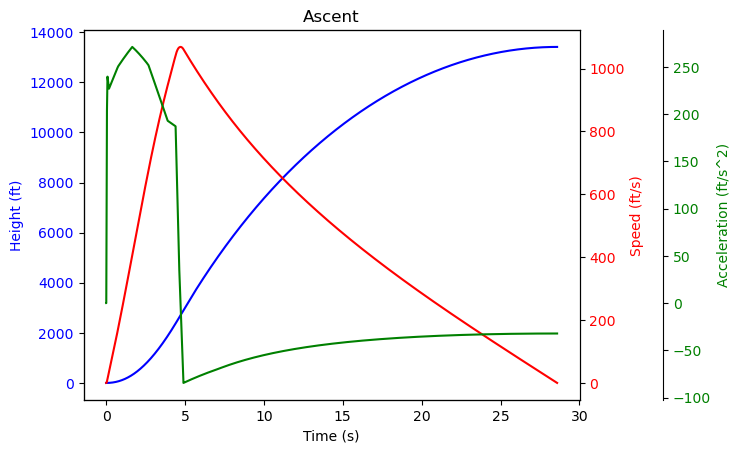

,Time (s),Height (ft),Speed (ft/s),Accel (ft/s^2),G-force (g),Re*10^7,q (kPa)
Max-g Force,1.65,320.72,406.90,271.04,8.42,1.42,7.46
Max Re,4.65,2643.69,1068.34,26.27,0.82,3.54,48.28
Max q,4.68,2669.34,1068.84,15.73,0.49,3.54,48.29
Max Speed,4.71,2706.75,1069.11,0.39,0.01,3.54,48.27
Burnout,4.90,2903.02,1061.70,-84.47,-2.63,3.50,47.35
Apogee,28.59,13412.62,0.05,-32.18,-1.00,0.00,0.00


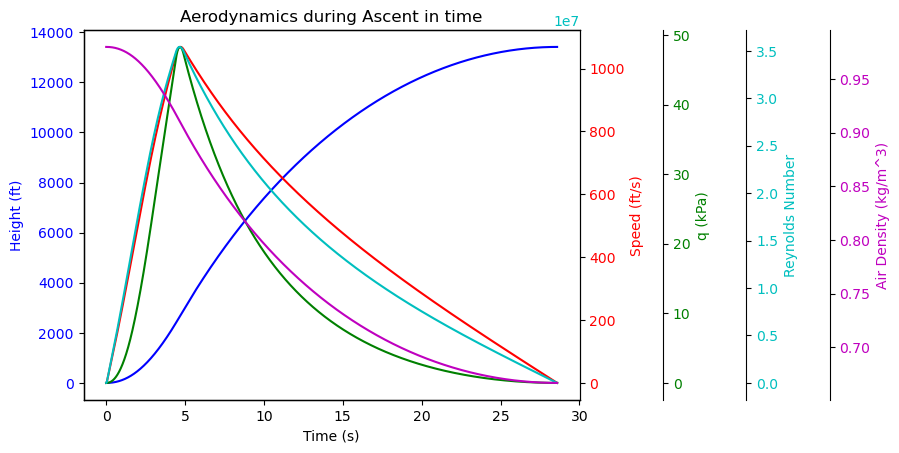

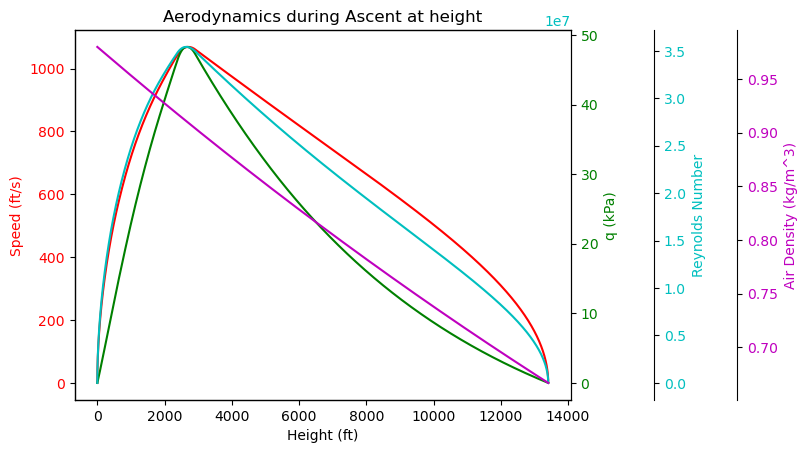

In [372]:
# Analyze Ascent
if dataset_choice != 'custom':
    # last 5 data points taken off so that the affects due to chute deployment at apogee aren't considered
    apogee_index = dataset['height'].idxmax()-5
else:
    apogee_index = dataset['height'].idxmax()

time = dataset['time'][:apogee_index]
height = dataset['height'][:apogee_index].copy()
speed = dataset['speed'][:apogee_index].copy()
accel = dataset['acceleration'][:apogee_index].copy()

unit = 'm'
if imperial: 
    height *= 3.281
    speed *= 3.281 
    accel *= 3.281
    unit = 'ft'

fig, ax1 = plt.subplots()
ax1.plot(time, height, color='b', label='Dataset 1')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel(f'Height ({unit})', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(time, speed, color='r', label='Dataset 2')
ax2.set_ylabel(f'Speed ({unit}/s)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(time, accel, color='g', label='Dataset 3')
ax3.set_ylabel(f'Acceleration ({unit}/s^2)', color='g')
ax3.tick_params(axis='y', labelcolor='g')

plt.title('Ascent')
plt.show()

max_g_index = accel.idxmax()
max_speed_index = speed.idxmax()
if dataset_choice == 'custom': # set it equal to the first index of dataset['time'] where it is greater than the final time in engine_thrust_lookup
    burnout_index = dataset['time'][dataset['time'].apply(lambda x: x > list(engine_thrust_lookup.keys())[-1])].idxmin()
else:
    dataset['Cd_rocket'] = dataset['reynolds_num'].apply(lambda x: Cd_rocket_at_Re(x))
    dataset['drag_force'] = dataset['q'] * dataset['Cd_rocket'] * A_rocket
    dataset['accel_plus_Fg_minus_drag'] = dataset['acceleration'] + F_gravity + dataset['drag_force']/dry_mass
    burnout_index = dataset['time'][dataset['accel_plus_Fg_minus_drag'].apply(lambda x: x < 0)].idxmin()
max_q_index = dataset['q'][:apogee_index].idxmax()
max_Re_index = dataset['reynolds_num'][:apogee_index].idxmax()

parameters_at_flight_events = pd.DataFrame({
    'Time (s)': [round(time.iloc[max_g_index],2), round(time.iloc[max_Re_index],2), round(time.iloc[max_q_index],2), round(time.iloc[max_speed_index],2), round(time.iloc[burnout_index],2), round(time.iloc[-1],2)],
    f'Height ({unit})': [round(height.iloc[max_g_index],2), round(height.iloc[max_Re_index],2), round(height.iloc[max_q_index],2), round(height.iloc[max_speed_index],2), round(height.iloc[burnout_index],2), round(height.iloc[-1],2)],
    f'Speed ({unit}/s)': [round(speed.iloc[max_g_index],2), round(speed.iloc[max_Re_index],2), round(speed.iloc[max_q_index],2), round(speed.iloc[max_speed_index],2), round(speed.iloc[burnout_index],2), round(speed.iloc[-1],2)],
    f'Accel ({unit}/s^2)': [round(accel.iloc[max_g_index],2), round(accel.iloc[max_Re_index],2), round(accel.iloc[max_q_index],2), round(accel.iloc[max_speed_index],2), round(accel.iloc[burnout_index],2), round(accel.iloc[-1],2)],
    f'G-force (g)': [round(dataset['acceleration'].iloc[max_g_index]/F_gravity,2), round(dataset['acceleration'].iloc[max_Re_index]/F_gravity,2), round(dataset['acceleration'].iloc[max_q_index]/F_gravity,2), round(dataset['acceleration'].iloc[max_speed_index]/F_gravity,2), round(dataset['acceleration'].iloc[burnout_index]/F_gravity,2), round(dataset['acceleration'].iloc[-1]/F_gravity,2)],
    f'Re*10^7': [round(dataset['reynolds_num'].iloc[max_g_index]/1e7,2), round(dataset['reynolds_num'].iloc[max_Re_index]/1e7,2), round(dataset['reynolds_num'].iloc[max_q_index]/1e7,2), round(dataset['reynolds_num'].iloc[max_speed_index]/1e7,2), round(dataset['reynolds_num'].iloc[burnout_index]/1e7,2), round(dataset['reynolds_num'].iloc[-1]/1e7,2)],
    f'q (kPa)': [round(dataset['q'].iloc[max_g_index]/1000,2), round(dataset['q'].iloc[max_Re_index]/1000,2), round(dataset['q'].iloc[max_q_index]/1000,2), round(dataset['q'].iloc[max_speed_index]/1000,2), round(dataset['q'].iloc[burnout_index]/1000,2), round(dataset['q'].iloc[-1]/1000,2)],
}, 
index=['Max-g Force', 'Max Re', 'Max q', 'Max Speed', 'Burnout', 'Apogee'])
display(parameters_at_flight_events.sort_values(by=['Time (s)']))

# Aerodynamic Forces during ascent

# note: plotting pressure against hieght of both Prometheus datasets on both ascent and descent shows them to be nearly identical. Given the significant change in speed on the way up vs the way down, this suggests that the pressure inside the av bay (which is what's read by the sensors) changes nearly instantaneously with the pressure outside, at least as far as it makes a difference for the changing rates in the max-q calculation. <- check if also consistent with other sim, note if it is

fig, ax1 = plt.subplots()
ax1.plot(time, height, color='b', label='Height')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel(f'Height ({unit})', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(time, speed, color='r', label='Speed')
ax2.set_ylabel(f'Speed ({unit}/s)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(time, dataset['q'][0:apogee_index]/1000, color='g', label='q')
ax3.set_ylabel('q (kPa)', color='g')
ax3.tick_params(axis='y', labelcolor='g')

ax4 = ax1.twinx()
ax4.spines['right'].set_position(('outward', 120))
ax4.plot(time, dataset['reynolds_num'][0:apogee_index], color='c', label='Reynolds Number')
ax4.set_ylabel('Reynolds Number', color='c')
ax4.tick_params(axis='y', labelcolor='c')

ax5 = ax1.twinx()
ax5.spines['right'].set_position(('outward', 180))
ax5.plot(time, dataset['air_density'][0:apogee_index], color='m', label='Air Density')
ax5.set_ylabel('Air Density (kg/m^3)', color='m')
ax5.tick_params(axis='y', labelcolor='m')

plt.title('Aerodynamics during Ascent in time')
plt.show()

fig2, ax1 = plt.subplots()
ax1.plot(height, speed, color='r', label='Speed')
ax1.set_xlabel(f'Height ({unit})')
ax1.set_ylabel(f'Speed ({unit}/s)', color='r')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2.plot(height, dataset['q'][0:apogee_index]/1000, color='g', label='q')
ax2.set_ylabel('q (kPa)', color='g')
ax2.tick_params(axis='y', labelcolor='g')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(height, dataset['reynolds_num'][0:apogee_index], color='c', label='Reynolds Number')
ax3.set_ylabel('Reynolds Number', color='c')
ax3.tick_params(axis='y', labelcolor='c')

ax4 = ax1.twinx()
ax4.spines['right'].set_position(('outward', 120))
ax4.plot(height, dataset['air_density'][0:apogee_index], color='m', label='Air Density')
ax4.set_ylabel('Air Density (kg/m^3)', color='m')
ax4.tick_params(axis='y', labelcolor='m')

plt.title('Aerodynamics during Ascent at height')
plt.show()

## Airbrakes Simulation

In [373]:
# Define airbrake parameters
num_flaps = 4
A_flap = 0.0064516 # 0.011408 is the current area in CAD, likely to decrease. 0.0064516 from Maryland's last year, which we'll probably have a similar configuration to
A_brakes = A_flap * num_flaps
Cd_brakes = 1 # about what other teams had, super rough
max_deployment_speed = 10 #deg/s

In [374]:
# Define PID controller class
class PIDController:
    def __init__(self, Kp, Ki, Kd, setpoint):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.setpoint = setpoint
        self.prev_error = 0
        self.integral = 0

    def calculate(self, process_variable, dt):
        error = self.setpoint - process_variable
        if error > 0:
            self.integral += error * dt
            derivative = (error - self.prev_error) / dt
            output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
            output = min(output, 45)
            output = max(output, 0)
            self.prev_error = error
        else:
            output = 45
        return output

In [375]:
# Airbrake deployment simulation

# set flightpath until airbrake deployment as identical
temp_at_launchpad = dataset['temperature'][0]
airbrake_deployment = burnout_index + 5
pre_brake_flight = dataset.head(airbrake_deployment).copy()
pre_brake_flight['deployment_angle']=0

# deploy airbrakes and see how flighpath changes. recalc everything at each timestep from moment deployed
height = pre_brake_flight['height'].iloc[-1]
deployment_height = height
speed = pre_brake_flight['speed'].iloc[-1]
time = pre_brake_flight['time'].iloc[-1]
mass = dry_mass
deployment_angle = 0
if dataset_choice == 'custom':
    timestep = 0.001
else:
    timestep = 0.01

# define PID controller
Kp = 1
Ki = 0
Kd = 0.4
setpoint = (10000/3.281) - deployment_height
pid = PIDController(Kp, Ki, Kd, setpoint)

# for efficiency, may be removed when the simulation is made more accurate by the cd changing during the sim:
A_Cd_brakes = A_brakes*Cd_brakes

airbrake_flight = []
while speed > 0:
    time += timestep

    temperature = temp_at_height(height,temp_at_launchpad)
    pressure = pressure_at_height(height,temp_at_launchpad, pressure_at_launchpad)
    air_density = air_density_fn(pressure, temperature)
    q = 0.5 * (air_density) * (speed**2)
    dynamic_viscosity = lookup_dynamic_viscosity(temperature, one_atm_air_dynamic_viscosity_lookup)
    reynolds_num = (air_density*speed*len_characteristic)/dynamic_viscosity
    Cd_rocket = Cd_rocket_at_Re(reynolds_num)

    PID_output = pid.calculate(height-deployment_height, timestep) 

    if PID_output>deployment_angle:
        deployment_angle = min(45, deployment_angle + max_deployment_speed*timestep)
    elif PID_output<deployment_angle:
        deployment_angle = max(0, deployment_angle - max_deployment_speed*timestep) 

    acceleration = -F_gravity - (np.sin(np.deg2rad(deployment_angle))*A_Cd_brakes + A_rocket*Cd_rocket)*q/mass
    height += speed*timestep
    speed += acceleration*timestep

#############
        
        #simulated_values.append([time, height, speed, acceleration, temperature, pressure, air_density, q, dynamic_viscosity, reynolds_num, Cd_rocket])


#############
    simulated_values = {
        'time': time,
        'height': height,
        'speed': speed,
        'temperature': temperature,
        'pressure': pressure,
        'acceleration': acceleration,
        'deployment_angle': deployment_angle
    }
    airbrake_flight.append(simulated_values)

ascent = pd.concat([pre_brake_flight, pd.DataFrame(airbrake_flight)], ignore_index=True)
ascent['q'] = 0.5 * air_density_fn(ascent['pressure'], ascent['temperature']) * (ascent['speed']**2)

# how high should the rocket overshoot without deployment, motor selction

## Analyze Airbrakes Flight

In [376]:
# Set Units
imperial = True

,Time (s),Height (ft),Speed (ft/s),Accel (ft/s^2),G-force (g)
Airbrakes Apogee,21.90,9593.05,-0.01,-32.18,-1.0
No Airbrakes Apogee,28.59,13412.62,0.05,-32.18,-1.0


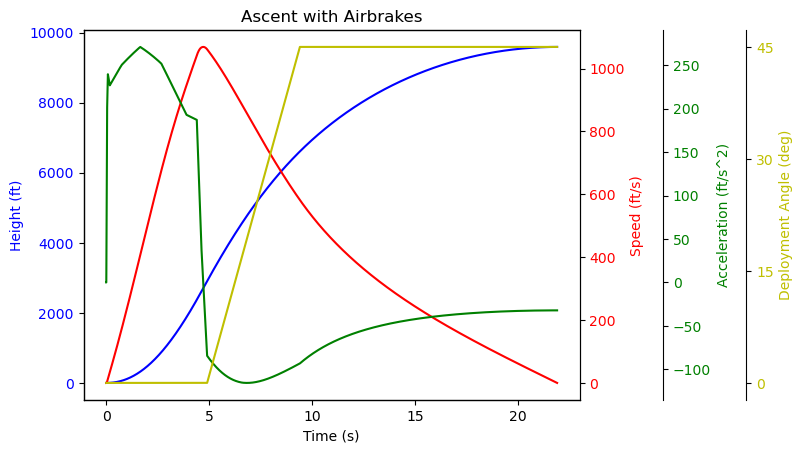

In [377]:
# Analyze Ascent
height = ascent['height'].copy()
speed = ascent['speed'].copy()
accel = ascent['acceleration'].copy()
apogee = ascent['height'].iloc[-1]
unit = 'm'
if imperial: 
    height *= 3.281
    speed *= 3.281 
    accel *= 3.281
    apogee *= 3.281
    unit = 'ft'

parameters_at_apogee = pd.DataFrame({
    'Time (s)': [round(ascent['time'].iloc[-1],2), round(parameters_at_flight_events.iloc[-1].iloc[0],2)],
    f'Height ({unit})': [round(height.iloc[-1],2), round(parameters_at_flight_events.iloc[-1].iloc[1],2)],
    f'Speed ({unit}/s)': [round(speed.iloc[-1],2), round(parameters_at_flight_events.iloc[-1].iloc[2],2)],
    f'Accel ({unit}/s^2)': [round(accel.iloc[-1],2), round(parameters_at_flight_events.iloc[-1].iloc[3],2)],
    f'G-force (g)': [round(ascent['acceleration'].iloc[-1]/F_gravity,2), round(parameters_at_flight_events.iloc[-1].iloc[4],2)]
}, 
index=['Airbrakes Apogee', 'No Airbrakes Apogee'])
display(parameters_at_apogee)


fig, ax1 = plt.subplots()
ax1.plot(ascent['time'], height, color='b')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel(f'Height ({unit})', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(ascent['time'], speed, color='r')
ax2.set_ylabel(f'Speed ({unit}/s)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(ascent['time'], accel, color='g')
ax3.set_ylabel(f'Acceleration ({unit}/s^2)', color='g')
ax3.tick_params(axis='y', labelcolor='g')

ax4 = ax1.twinx()
ax4.spines['right'].set_position(('outward', 120))
ax4.plot(ascent['time'], ascent['deployment_angle'], color='y')
ax4.set_ylabel(f'Deployment Angle (deg)', color='y')
ax4.tick_params(axis='y', labelcolor='y')
ax4.set_yticks(range(0, 46, 15))

plt.title('Ascent with Airbrakes')
plt.show()

,Time (s),Height (ft),Speed (ft/s),Accel (ft/s^2),G-force (g),Re*10^7,q (kPa),Cumulative Impulse from total drag (N*s),Cumulative Impulse from airbrakes drag (N*s),Cumulative Final Apogee Change from total drag (ft),Cumulative Final Apogee Change from airbrakes drag (ft)
Max-g Force,1.65,320.72,406.90,271.04,8.42,1.42,7.46,24.95,0.00,86.20,0.00
Max Re,4.65,2643.69,1068.34,26.27,0.82,3.54,48.28,560.75,0.00,1907.03,0.00
Max q,4.68,2669.34,1068.84,15.73,0.49,3.54,48.29,568.21,0.00,1931.92,0.00
Max Speed,4.71,2706.75,1069.11,0.39,0.01,3.54,48.27,579.08,0.00,1968.15,0.00
Burnout,4.90,2903.02,1061.70,-84.47,-2.63,3.50,47.35,635.84,0.00,2156.20,0.00
Apogee,21.90,9593.05,-0.01,-32.18,-1.00,0.00,0.00,3340.12,1651.78,9021.48,4008.94


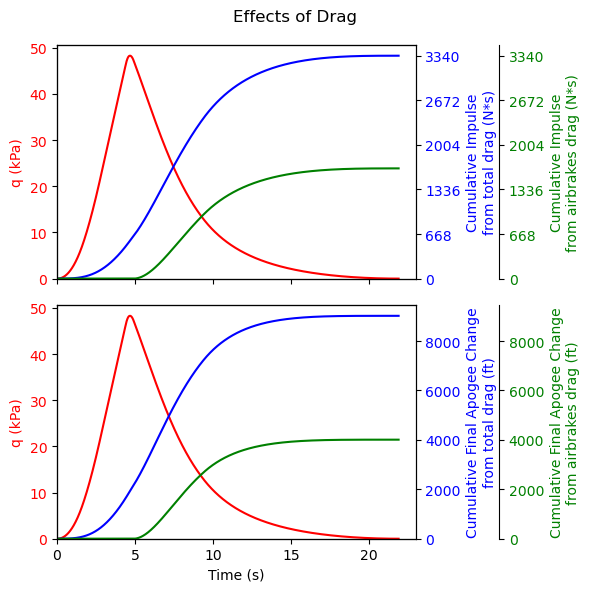

In [378]:
# Effects of drag
timestep = (ascent['time'].iloc[-1]-ascent['time'].iloc[0])/len(ascent['time'])

impulse_due_to_total_drag, final_apogee_change_due_to_total_drag = [], []
for i in range(len(ascent)):
    impulse_due_to_total_drag.append((ascent['q'][i]*timestep*(np.sin(np.deg2rad(ascent['deployment_angle'][i]))*A_Cd_brakes+Cd_rocket*A_rocket)))
    final_apogee_change_due_to_total_drag.append(impulse_due_to_total_drag[i]/mass_at_time(ascent['time'].iloc[i],dry_mass,engine_mass_lookup)*(ascent['time'].iloc[-1]-ascent['time'].iloc[i]))

cumulative_impulse_due_to_total_drag, cumulative_final_apogee_change_due_to_total_drag = [0], [0]
for i in range(len(impulse_due_to_total_drag)-1): 
    cumulative_impulse_due_to_total_drag.append(cumulative_impulse_due_to_total_drag[i]+impulse_due_to_total_drag[i])
    cumulative_final_apogee_change_due_to_total_drag.append(final_apogee_change_due_to_total_drag[i]+cumulative_final_apogee_change_due_to_total_drag[i])

impulse_due_to_airbrakes_drag, final_apogee_change_due_to_airbrakes_drag = [], []
for i in range(len(ascent)):
    impulse_due_to_airbrakes_drag.append((ascent['q'][i]*timestep*np.sin(np.deg2rad(ascent['deployment_angle'][i]))*A_Cd_brakes))
    final_apogee_change_due_to_airbrakes_drag.append(impulse_due_to_airbrakes_drag[i]/mass_at_time(ascent['time'].iloc[i],dry_mass,engine_mass_lookup)*(ascent['time'].iloc[-1]-ascent['time'].iloc[i]))

cumulative_impulse_due_to_airbrakes_drag, cumulative_final_apogee_change_due_to_airbrakes_drag = [0], [0]
for i in range(len(impulse_due_to_airbrakes_drag)-1): 
    cumulative_impulse_due_to_airbrakes_drag.append(cumulative_impulse_due_to_airbrakes_drag[i]+impulse_due_to_airbrakes_drag[i])
    cumulative_final_apogee_change_due_to_airbrakes_drag.append(final_apogee_change_due_to_airbrakes_drag[i]+cumulative_final_apogee_change_due_to_airbrakes_drag[i])

if imperial:
    cumulative_final_apogee_change_due_to_total_drag = [i*3.281 for i in cumulative_final_apogee_change_due_to_total_drag]
    cumulative_final_apogee_change_due_to_airbrakes_drag = [i*3.281 for i in cumulative_final_apogee_change_due_to_airbrakes_drag]

effects_of_drag_over_flight = pd.DataFrame({
    'Time (s)': [round(ascent['time'].iloc[max_g_index],2), round(ascent['time'].iloc[max_Re_index],2), round(ascent['time'].iloc[max_q_index],2), round(ascent['time'].iloc[max_speed_index],2), round(ascent['time'].iloc[burnout_index],2), round(ascent['time'].iloc[-1],2)],
    f'Height ({unit})': [round(height.iloc[max_g_index],2), round(height.iloc[max_Re_index],2), round(height.iloc[max_q_index],2), round(height.iloc[max_speed_index],2), round(height.iloc[burnout_index],2), round(height.iloc[-1],2)],
    f'Speed ({unit}/s)': [round(speed.iloc[max_g_index],2), round(speed.iloc[max_Re_index],2), round(speed.iloc[max_q_index],2), round(speed.iloc[max_speed_index],2), round(speed.iloc[burnout_index],2), round(speed.iloc[-1],2)],
    f'Accel ({unit}/s^2)': [round(accel.iloc[max_g_index],2), round(accel.iloc[max_Re_index],2), round(accel.iloc[max_q_index],2), round(accel.iloc[max_speed_index],2), round(accel.iloc[burnout_index],2), round(accel.iloc[-1],2)],
    f'G-force (g)': [round(dataset['acceleration'].iloc[max_g_index]/F_gravity,2), round(dataset['acceleration'].iloc[max_Re_index]/F_gravity,2), round(dataset['acceleration'].iloc[max_q_index]/F_gravity,2), round(dataset['acceleration'].iloc[max_speed_index]/F_gravity,2), round(dataset['acceleration'].iloc[burnout_index]/F_gravity,2), round(dataset['acceleration'].iloc[-1]/F_gravity,2)],
    f'Re*10^7': [round(dataset['reynolds_num'].iloc[max_g_index]/1e7,2), round(dataset['reynolds_num'].iloc[max_Re_index]/1e7,2), round(dataset['reynolds_num'].iloc[max_q_index]/1e7,2), round(dataset['reynolds_num'].iloc[max_speed_index]/1e7,2), round(dataset['reynolds_num'].iloc[burnout_index]/1e7,2), round(dataset['reynolds_num'].iloc[-1]/1e7,2)],
    f'q (kPa)': [round(dataset['q'].iloc[max_g_index]/1000,2), round(dataset['q'].iloc[max_Re_index]/1000,2), round(dataset['q'].iloc[max_q_index]/1000,2), round(dataset['q'].iloc[max_speed_index]/1000,2), round(dataset['q'].iloc[burnout_index]/1000,2), round(dataset['q'].iloc[-1]/1000,2)],
    f'Cumulative Impulse from total drag (N*s)': [round(cumulative_impulse_due_to_total_drag[max_g_index],2), round(cumulative_impulse_due_to_total_drag[max_Re_index],2), round(cumulative_impulse_due_to_total_drag[max_q_index],2), round(cumulative_impulse_due_to_total_drag[max_speed_index],2), round(cumulative_impulse_due_to_total_drag[burnout_index],2), round(cumulative_impulse_due_to_total_drag[-1],2)],
    f'Cumulative Impulse from airbrakes drag (N*s)': [round(cumulative_impulse_due_to_airbrakes_drag[max_g_index],2), round(cumulative_impulse_due_to_airbrakes_drag[max_Re_index],2), round(cumulative_impulse_due_to_airbrakes_drag[max_q_index],2), round(cumulative_impulse_due_to_airbrakes_drag[max_speed_index],2), round(cumulative_impulse_due_to_airbrakes_drag[burnout_index],2), round(cumulative_impulse_due_to_airbrakes_drag[-1],2)],
    f'Cumulative Final Apogee Change from total drag ({unit})': [round(cumulative_final_apogee_change_due_to_total_drag[max_g_index],2), round(cumulative_final_apogee_change_due_to_total_drag[max_Re_index],2), round(cumulative_final_apogee_change_due_to_total_drag[max_q_index],2), round(cumulative_final_apogee_change_due_to_total_drag[max_speed_index],2), round(cumulative_final_apogee_change_due_to_total_drag[burnout_index],2), round(cumulative_final_apogee_change_due_to_total_drag[-1],2)],
    f'Cumulative Final Apogee Change from airbrakes drag ({unit})': [round(cumulative_final_apogee_change_due_to_airbrakes_drag[max_g_index],2), round(cumulative_final_apogee_change_due_to_airbrakes_drag[max_Re_index],2), round(cumulative_final_apogee_change_due_to_airbrakes_drag[max_q_index],2), round(cumulative_final_apogee_change_due_to_airbrakes_drag[max_speed_index],2), round(cumulative_final_apogee_change_due_to_airbrakes_drag[burnout_index],2), round(cumulative_final_apogee_change_due_to_airbrakes_drag[-1],2)],
},
index=['Max-g Force', 'Max Re', 'Max q', 'Max Speed', 'Burnout', 'Apogee'])
display(effects_of_drag_over_flight.sort_values(by=['Time (s)']))


fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, figsize=(6,6))
fig.suptitle('Effects of Drag')
# plot speed
ax1.plot(np.arange(0,len(ascent))*timestep, ascent['q']/1000, color='r')
ax1.set_ylabel('q (kPa)', color='r')
ax1.tick_params(axis='y', labelcolor='r')
ax1.set_ylim(bottom=0)
ax1.set_xlim(left=0)
# plot cumulative impulse due to total drag
ax1_2 = ax1.twinx()
ax1_2.plot(np.arange(0,len(ascent))*timestep, cumulative_impulse_due_to_total_drag, color='b')
ax1_2.set_ylabel(f'Cumulative Impulse\nfrom total drag (N*s)', color='b')
ax1_2.tick_params(axis='y', labelcolor='b')
ax1_2.set_ylim([0, max(cumulative_impulse_due_to_total_drag)*1.05])
# plot cumulative impulse due to airbrakes drag
ax1_3 = ax1.twinx()
ax1_3.spines['right'].set_position(('outward', 60))
ax1_3.plot(np.arange(0,len(ascent))*timestep, cumulative_impulse_due_to_airbrakes_drag, color='g')
ax1_3.set_ylabel(f'Cumulative Impulse\nfrom airbrakes drag (N*s)', color='g')
ax1_3.tick_params(axis='y', labelcolor='g')
ax1_3.set_ylim([0, max(cumulative_impulse_due_to_total_drag)*1.05])

ax1_2.set_yticks(np.linspace(0, max(cumulative_impulse_due_to_total_drag), 6))
ax1_3.set_yticks(np.linspace(0, max(cumulative_impulse_due_to_total_drag), 6))

ax2.set_xlabel('Time (s)')

ax2.plot(np.arange(0,len(ascent))*timestep, ascent['q']/1000, color='r')
ax2.set_ylabel('q (kPa)', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylim(bottom=0)

ax2_2 = ax2.twinx()
ax2_2.plot(np.arange(0,len(ascent))*timestep, cumulative_final_apogee_change_due_to_total_drag, color='b')
ax2_2.set_ylabel(f'Cumulative Final Apogee Change\nfrom total drag ({unit})', color='b')
ax2_2.tick_params(axis='y', labelcolor='b')
ax2_2.set_ylim([0, max(cumulative_final_apogee_change_due_to_total_drag)*1.05])

ax2_3 = ax2.twinx()
ax2_3.spines['right'].set_position(('outward', 60))
ax2_3.plot(np.arange(0,len(ascent))*timestep, cumulative_final_apogee_change_due_to_airbrakes_drag, color='g')
ax2_3.set_ylabel(f'Cumulative Final Apogee Change\nfrom airbrakes drag ({unit})', color='g')
ax2_3.tick_params(axis='y', labelcolor='g')
ax2_3.set_ylim([0, max(cumulative_final_apogee_change_due_to_total_drag)*1.05])

plt.tight_layout()
plt.show()